In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os

os.makedirs('outputs', exist_ok=True)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# loading and cleaning

In [29]:
df = pd.read_csv('archive/online_retail_II.csv', encoding='ISO-8859-1')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [30]:
df = df[df['Quantity'] > 0][df['Price'] > 0]
df.dropna(subset=["Customer ID"], inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalAmount'] = df['Quantity'] * df['Price']

print(f"{df['Customer ID'].nunique():,} customers analyzed")

5,878 customers analyzed


# RFM

In [31]:
reference_date = df['InvoiceDate'].max()
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalAmount': 'sum'
}).round(2)

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm[(rfm["Monetary"] > 0) & (rfm['Frequency'] > 0)]


* BUlletproof rfm scoring

In [32]:
def rfm_score(x):
    return pd.cut(x.rank(pct=True) * 5, bins=5, labels=[5,4,3,2,1])

rfm['R_Score'] = rfm_score(rfm['Recency'])
rfm['F_Score'] = rfm_score(rfm['Frequency'])
rfm['M_Score'] = rfm_score(rfm['Monetary'])

rfm['Segment'] = np.select(
    [
        (rfm['R_Score']>=4) & (rfm['F_Score']>=4),
        (rfm['R_Score']>=3) & (rfm['F_Score']>=3),
        (rfm['R_Score']<=2) & (rfm['F_Score']>=3),
        (rfm['R_Score']==1) & (rfm['F_Score']<=2)
    ],
    ['Champions', 'Loyal', 'At Risk', 'Lost'],
    default='Others'
)

print("Segments created")

Segments created


# Clustering

In [33]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency','Monetary']])
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


* Results

In [34]:
revenue = rfm.groupby('Segment')['Monetary'].agg(['count', 'sum', 'mean']).round(2)
revenue.columns = ['Customers','Revenue', 'AvgSpend']
revenue['Rev%'] = (revenue['Revenue']/revenue['Revenue'].sum()*100).round(1)


print("\n REVENUE ANALYSIS")
print(revenue)
print(f"\n champions contribute {revenue.loc['Champions', 'Rev%']:.1f}% revenue")



 REVENUE ANALYSIS
           Customers     Revenue  AvgSpend  Rev%
Segment                                         
At Risk         1014  9399814.53   9270.03  53.0
Champions       3117  7525465.73   2414.33  42.4
Lost             716   245009.71    342.19   1.4
Others          1031   573139.19    555.91   3.2

 champions contribute 42.4% revenue


# Graphs

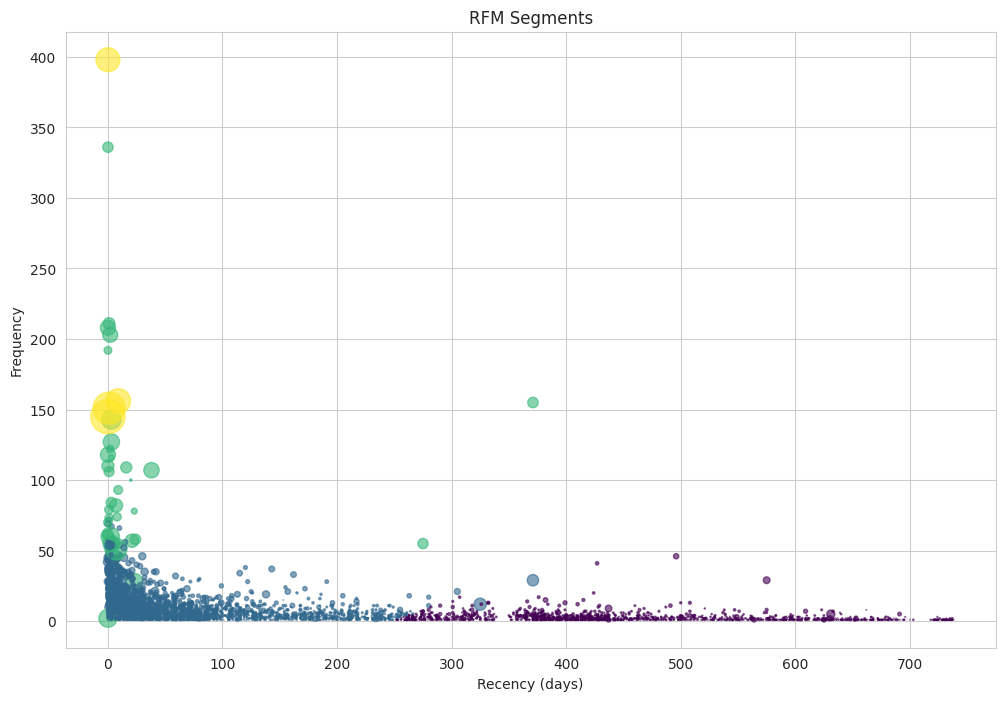

In [35]:
plt.figure(figsize=(12,8))
plt.scatter(rfm['Recency'], rfm['Frequency'], c=rfm['Cluster'],
            s=rfm['Monetary']/1000, cmap='viridis', alpha=0.6)
plt.xlabel('Recency (days)'); plt.ylabel('Frequency'); plt.title('RFM Segments')
plt.savefig('outputs/rfm_clusters.png', dpi=300)
plt.show()


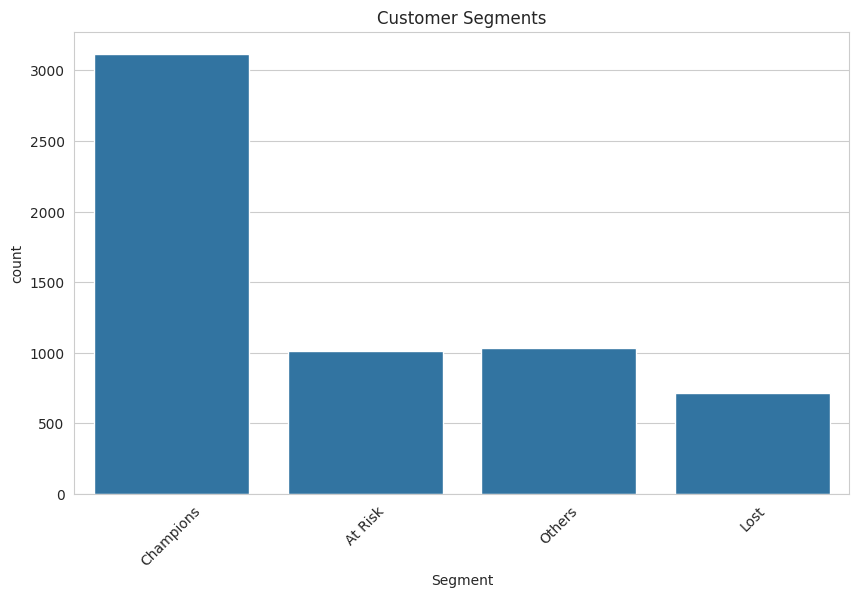

In [36]:
plt.figure(figsize=(10,6))
sns.countplot(data=rfm, x='Segment')
plt.title('Customer Segments')
plt.xticks(rotation=45)
plt.savefig('outputs/segments.png', dpi=300)
plt.show()